In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [55]:
device = 'cuda'

In [56]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

torch.manual_seed(42)

from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [57]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [58]:
first_piece['timestamps'] = first_piece.index
first_piece

/tmp/ipykernel_107293/4257701824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamps'] = first_piece.index


,O2_avg,timestamps
2017-07-11 14:00:00,244.479760,2017-07-11 14:00:00
2017-07-11 14:05:00,245.013691,2017-07-11 14:05:00
2017-07-11 14:10:00,246.106549,2017-07-11 14:10:00
2017-07-11 14:15:00,244.890977,2017-07-11 14:15:00
2017-07-11 14:20:00,244.949879,2017-07-11 14:20:00
...,...,...
2017-07-12 05:40:00,237.429344,2017-07-12 05:40:00
2017-07-12 05:45:00,237.754546,2017-07-12 05:45:00
2017-07-12 05:50:00,237.742503,2017-07-12 05:50:00
2017-07-12 05:55:00,237.609201,2017-07-12 05:55:00


In [59]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')

In [60]:
# training_data, test_gen = split(ds_one, offset=-36)
# test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# # Train the model and make predictions
# model = DeepAREstimator(
#     prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
# ).train(training_data)

# forecasts = list(model.predict(test_data.input))

# # Plot predictions
# plt.plot(df["1954":], color="black")
# for forecast in forecasts:
#   forecast.plot()
# plt.legend(["True values"], loc="upper left", fontsize="xx-large")
# plt.show()

In [61]:
# def highlight_entry(entry, color):
#     start = entry["start"]
#     end = entry["start"] + len(entry["target"])
#     plt.axvspan(start, end, facecolor=color, alpha=0.2)


# def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
#     for original_entry, train_entry in zip(original_dataset, training_dataset):
#         original_entry.plot()
#         highlight_entry(train_entry, "red")
#         plt.legend(["sub dataset", "training dataset"], loc="upper left")
#         plt.show()

#     for original_entry in original_dataset:
#         for test_input, test_label in test_pairs:
#             original_entry.plot()
#             highlight_entry(test_input, "green")
#             highlight_entry(test_label, "blue")
#             plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
#             plt.show()

In [62]:
from gluonts.dataset.util import to_pandas

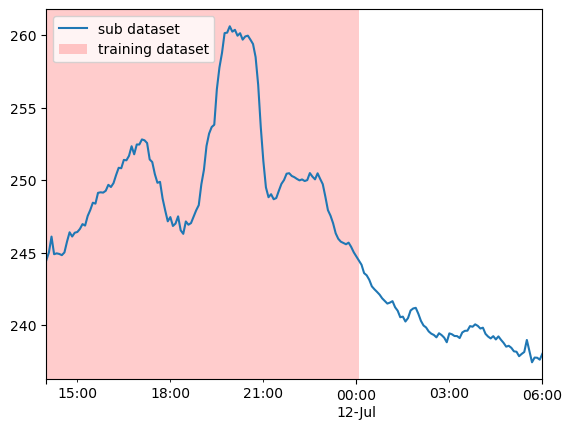

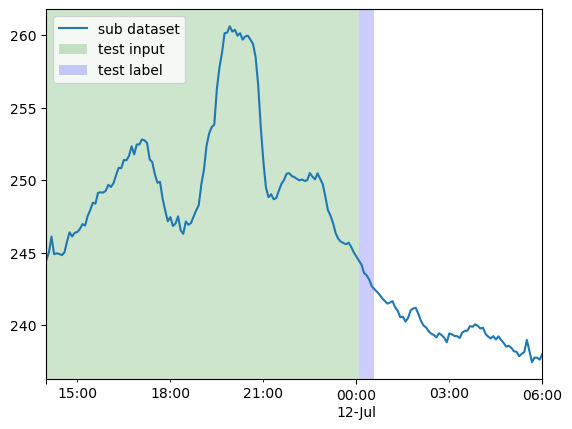

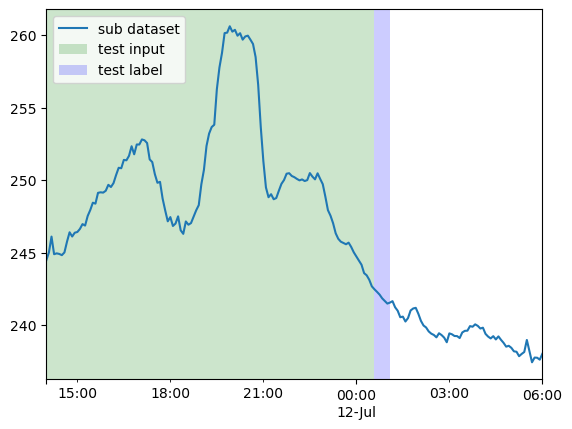

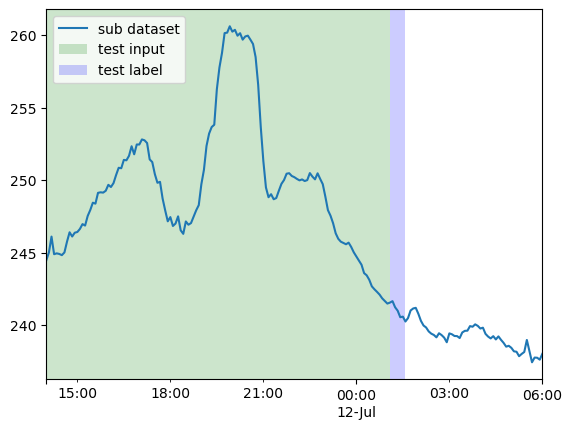

In [63]:
def _to_datetime_index(s_or_df):
    obj = s_or_df.copy()
    if isinstance(obj.index, pd.PeriodIndex):
        obj.index = obj.index.to_timestamp()  # cast to DatetimeIndex
    return obj

def highlight_entry(entry, color):
    # entry["start"] is a pandas.Period, entry["target"] is an array-like
    start_period = entry["start"]
    n = int(len(entry["target"]))
    # left = start of the first period, right = start of the period AFTER the last step
    left = start_period.to_timestamp()
    right = (start_period + n).to_timestamp()
    plt.axvspan(left, right, facecolor=color, alpha=0.2)

def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        s = _to_datetime_index(to_pandas(original_entry))
        ax = s.plot()
        highlight_entry(train_entry, "red")
        ax.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            s = _to_datetime_index(to_pandas(original_entry))
            ax = s.plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            ax.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()
            
prediction_length = 6 # Preditct next 30 minutes
training_dataset, test_template = split(
    ds_one, date=pd.Period("2017-07-12 00:00:00", freq="5min")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

training_dataset
plot_dataset_splitting(ds_one, training_dataset, test_pairs)

In [64]:
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=prediction_length,
    trainer_kwargs={"max_epochs": 50}
)

predictor = estimator.train(training_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/raman-pc/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 26.8 K | train | [[1, 1], [1, 1], [1, 1158, 6], [1, 1158], [1, 1158], [1, 6, 6]] | [1, 100, 6]
------------------------------------------------------------------------------------------------------------------------------
26.8 K    Trainable params
0         Non-trainable params
26.8 K    Total params
0.107     Total estimated model params size (MB)
11        Modules in t

Epoch 0: |          | 50/? [00:01<00:00, 36.87it/s, v_num=16, train_loss=5.980]

Epoch 0, global step 50: 'train_loss' reached 5.98075 (best 5.98075), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 36.68it/s, v_num=16, train_loss=3.710]

Epoch 1, global step 100: 'train_loss' reached 3.71429 (best 3.71429), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 35.69it/s, v_num=16, train_loss=3.150]

Epoch 2, global step 150: 'train_loss' reached 3.14529 (best 3.14529), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 36.03it/s, v_num=16, train_loss=3.030]

Epoch 3, global step 200: 'train_loss' reached 3.03254 (best 3.03254), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:00<00:00, 452.89it/s, v_num=16, train_loss=2.950]  

Epoch 4, global step 250: 'train_loss' reached 2.94842 (best 2.94842), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 35.84it/s, v_num=16, train_loss=2.910] 

Epoch 5, global step 300: 'train_loss' reached 2.90994 (best 2.90994), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 32.24it/s, v_num=16, train_loss=2.880]

Epoch 6, global step 350: 'train_loss' reached 2.88144 (best 2.88144), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:01<00:00, 35.10it/s, v_num=16, train_loss=2.810]

Epoch 7, global step 400: 'train_loss' reached 2.80748 (best 2.80748), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:01<00:00, 34.21it/s, v_num=16, train_loss=2.760]

Epoch 8, global step 450: 'train_loss' reached 2.76278 (best 2.76278), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:01<00:00, 34.54it/s, v_num=16, train_loss=2.740]

Epoch 9, global step 500: 'train_loss' reached 2.74428 (best 2.74428), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:01<00:00, 34.66it/s, v_num=16, train_loss=2.730]

Epoch 10, global step 550: 'train_loss' reached 2.73405 (best 2.73405), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:01<00:00, 33.43it/s, v_num=16, train_loss=2.730]

Epoch 11, global step 600: 'train_loss' reached 2.73168 (best 2.73168), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:01<00:00, 34.03it/s, v_num=16, train_loss=2.670]

Epoch 12, global step 650: 'train_loss' reached 2.67357 (best 2.67357), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:01<00:00, 34.88it/s, v_num=16, train_loss=2.710]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 32.96it/s, v_num=16, train_loss=2.650]

Epoch 14, global step 750: 'train_loss' reached 2.65035 (best 2.65035), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:01<00:00, 34.33it/s, v_num=16, train_loss=2.660]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 35.83it/s, v_num=16, train_loss=2.700]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 37.22it/s, v_num=16, train_loss=2.520]

Epoch 17, global step 900: 'train_loss' reached 2.52107 (best 2.52107), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:01<00:00, 37.38it/s, v_num=16, train_loss=2.430]

Epoch 18, global step 950: 'train_loss' reached 2.42791 (best 2.42791), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:01<00:00, 36.45it/s, v_num=16, train_loss=2.650]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 36.07it/s, v_num=16, train_loss=2.390]

Epoch 20, global step 1050: 'train_loss' reached 2.39383 (best 2.39383), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:01<00:00, 36.20it/s, v_num=16, train_loss=2.830]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 37.82it/s, v_num=16, train_loss=2.670]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 38.17it/s, v_num=16, train_loss=2.610]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 38.43it/s, v_num=16, train_loss=2.620]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 36.38it/s, v_num=16, train_loss=2.600]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:00<00:00, 936.80it/s, v_num=16, train_loss=2.520]  

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 35.50it/s, v_num=16, train_loss=2.580] 

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 33.05it/s, v_num=16, train_loss=2.420]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 36.38it/s, v_num=16, train_loss=2.440]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 37.86it/s, v_num=16, train_loss=2.380]

Epoch 30, global step 1550: 'train_loss' reached 2.37909 (best 2.37909), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:01<00:00, 38.85it/s, v_num=16, train_loss=2.380]

Epoch 31, global step 1600: 'train_loss' reached 2.37843 (best 2.37843), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:01<00:00, 37.69it/s, v_num=16, train_loss=2.380]

Epoch 32, global step 1650: 'train_loss' reached 2.37826 (best 2.37826), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:01<00:00, 36.77it/s, v_num=16, train_loss=2.380]

Epoch 33, global step 1700: 'train_loss' reached 2.37814 (best 2.37814), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:01<00:00, 34.74it/s, v_num=16, train_loss=2.610]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 36.96it/s, v_num=16, train_loss=2.510]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 36.00it/s, v_num=16, train_loss=2.330]

Epoch 36, global step 1850: 'train_loss' reached 2.32862 (best 2.32862), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:01<00:00, 36.95it/s, v_num=16, train_loss=2.320]

Epoch 37, global step 1900: 'train_loss' reached 2.32231 (best 2.32231), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:01<00:00, 35.65it/s, v_num=16, train_loss=2.330]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 35.08it/s, v_num=16, train_loss=2.330]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 33.17it/s, v_num=16, train_loss=2.300]

Epoch 40, global step 2050: 'train_loss' reached 2.29893 (best 2.29893), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:01<00:00, 38.19it/s, v_num=16, train_loss=2.310]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.03it/s, v_num=16, train_loss=2.300]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 40.45it/s, v_num=16, train_loss=2.310]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 38.53it/s, v_num=16, train_loss=2.300]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 38.46it/s, v_num=16, train_loss=2.330]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 38.16it/s, v_num=16, train_loss=2.320]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 36.90it/s, v_num=16, train_loss=2.300]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 35.55it/s, v_num=16, train_loss=2.290]

Epoch 48, global step 2450: 'train_loss' reached 2.28899 (best 2.28899), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_16/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:01<00:00, 33.78it/s, v_num=16, train_loss=2.290]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:01<00:00, 33.71it/s, v_num=16, train_loss=2.290]


In [65]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
first_pair = next(iter(test_pairs))
second_pair = next(iter(test_pairs))
third_pair = next(iter(test_pairs))

forecast_it, ts_it = make_evaluation_predictions(
    dataset=first_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)


Running evaluation: 2it [00:00, 51.39it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


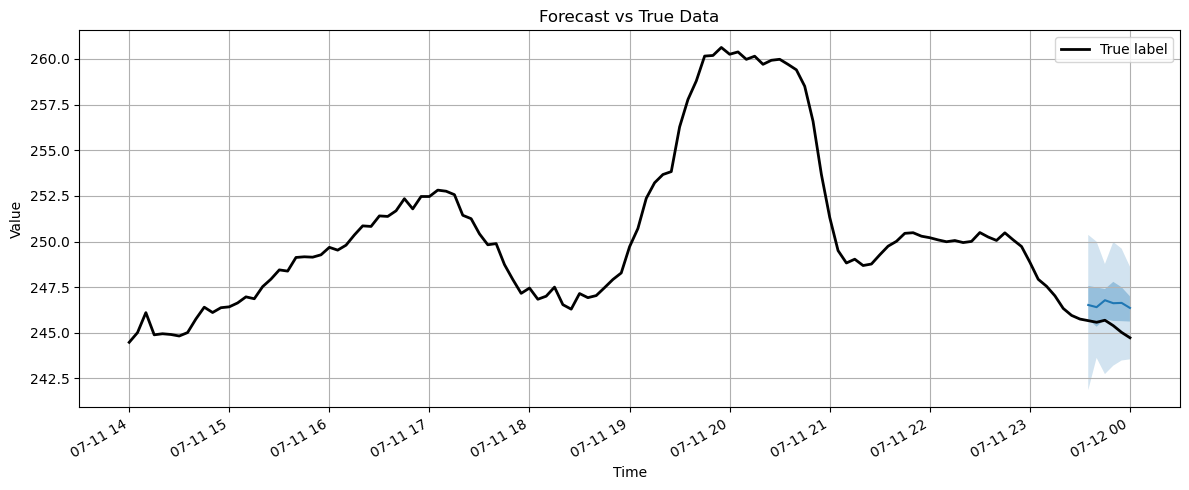

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


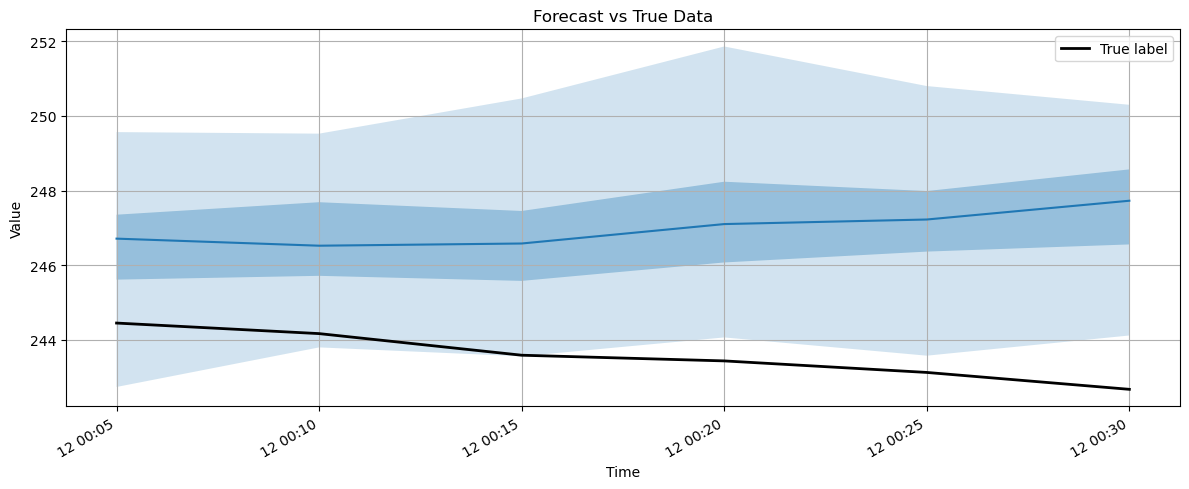

In [67]:
# Select forecast and label
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Running evaluation: 2it [00:00, 47.15it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

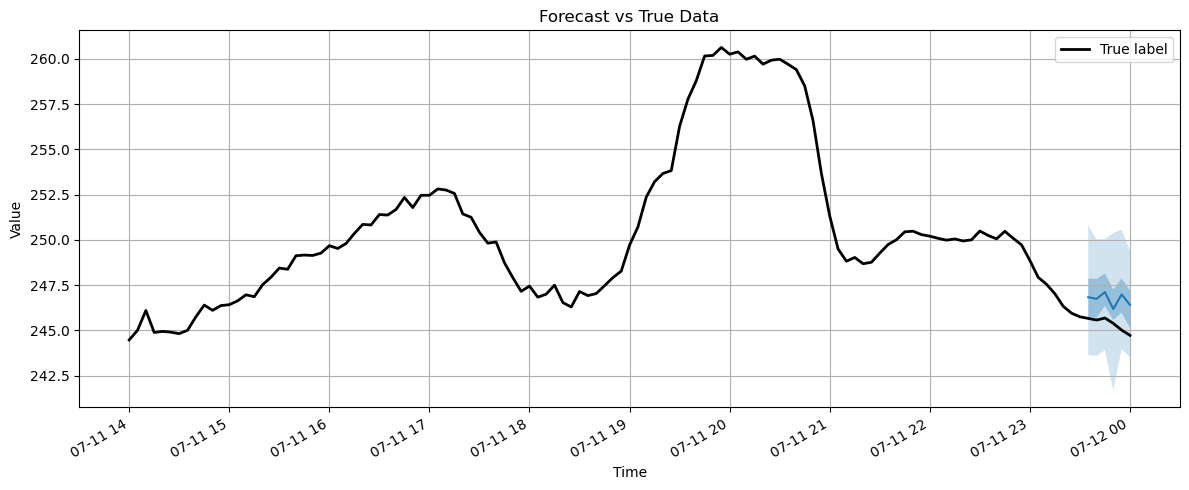

In [68]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=second_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


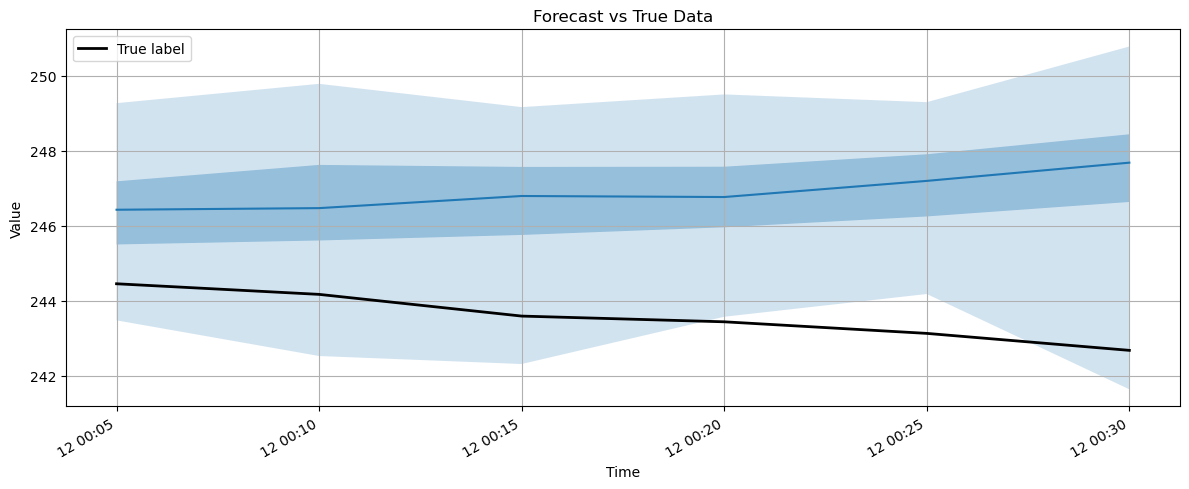

In [69]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Running evaluation: 2it [00:00, 47.80it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

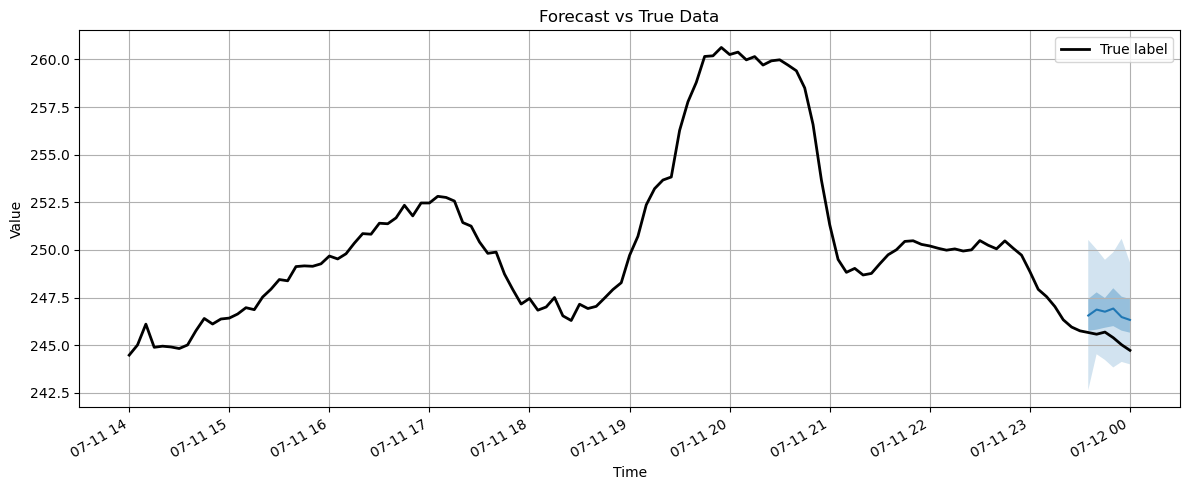

In [70]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=third_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


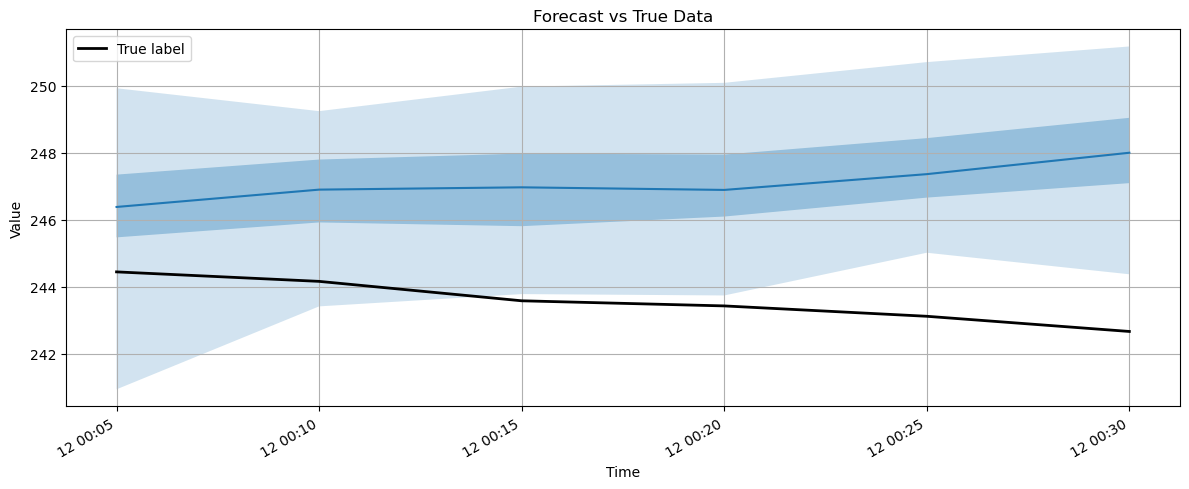

In [71]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()